In [3]:
import pandas as pd
import numpy as np
import os
import psycopg2
conn = psycopg2.connect(dbname='Yellow-Taxi', user='postgres', password='7466239', host='localhost', port='5432')
# Open a cursor to perform database operations
cur = conn.cursor()

C:\Users\Mark Rozenberg\AppData\Local\Temp\ipykernel_6036\3141687246.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  taxi_data_summary = pd.read_sql_query('select avg_temperature, num_trips from taxi_data_summary', conn)


<Figure size 1200x600 with 0 Axes>

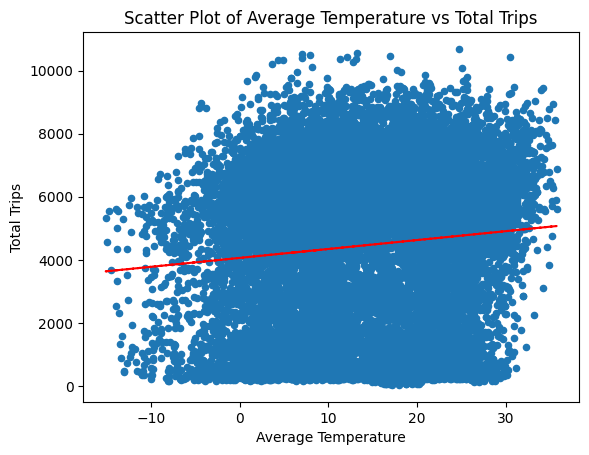

In [10]:
import matplotlib.pyplot as plt

# Fetch data from the taxi_data_summary table
taxi_data_summary = pd.read_sql_query('select avg_temperature, num_trips from taxi_data_summary', conn)
# Drop rows with NaN values in avg_temperature
taxi_data_summary_clean = taxi_data_summary.dropna(subset=['avg_temperature'])
plt.figure(figsize=(12, 6))
taxi_data_summary_clean.plot.scatter(x='avg_temperature', y='num_trips')
# Add a trend line
z = np.polyfit(taxi_data_summary_clean['avg_temperature'], taxi_data_summary_clean['num_trips'], 1)
p = np.poly1d(z)
plt.plot(taxi_data_summary_clean['avg_temperature'], p(taxi_data_summary_clean['avg_temperature']), "r--")
plt.xlabel('Average Temperature')
plt.ylabel('Total Trips')
plt.title('Scatter Plot of Average Temperature vs Total Trips')
plt.show()

In [3]:
pd.read_sql_query('select * from taxi_data_summary limit 2', conn).columns

C:\Users\Mark Rozenberg\AppData\Local\Temp\ipykernel_44852\1819124563.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query('select * from taxi_data_summary limit 2', conn).columns


Index(['rounded_date', 'num_trips', 'total_passengers', 'total_distance',
       'num_store_and_fwd', 'num_payment_type_0', 'num_payment_type_1',
       'num_payment_type_2', 'num_payment_type_3', 'num_payment_type_4',
       'num_payment_type_5', 'total_fare', 'num_extra', 'total_extra',
       'total_mta_tax', 'num_tips', 'total_tips', 'num_tolls', 'total_tolls',
       'num_improvement_surcharge', 'total_improvement_surcharge',
       'total_amount', 'num_congestion_surcharge',
       'total_congestion_surcharge', 'num_airport_fee', 'total_airport_fee',
       'avg_temperature', 'avg_wind_speed', 'avg_precipitation',
       'avg_relative_humidity', 'avg_visibility'],
      dtype='object')

C:\Users\Mark Rozenberg\AppData\Local\Temp\ipykernel_9708\3008984768.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  taxi_data_summary = pd.read_sql_query('''


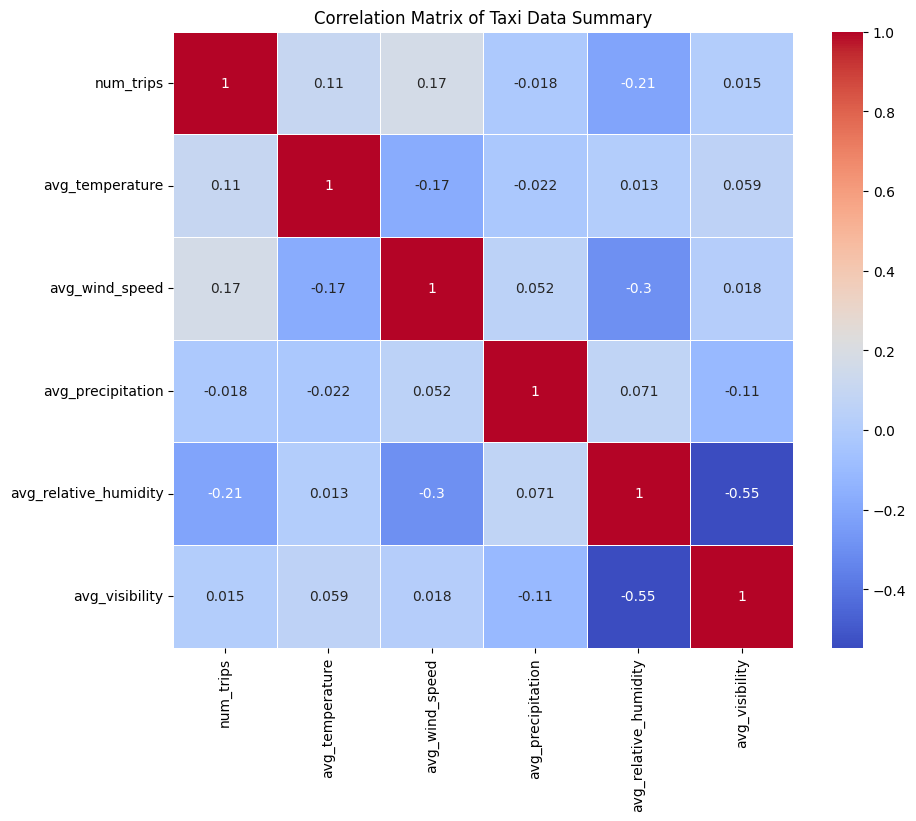

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming taxi_data_summary has other climate variables along with avg_temperature and num_trips
# Fetch the data
taxi_data_summary = pd.read_sql_query('''
select
num_trips,
avg_temperature,
avg_wind_speed,
avg_precipitation,
avg_relative_humidity,
avg_visibility
from taxi_data_summary
''', conn)

# Calculate the correlation matrix
correlation_matrix = taxi_data_summary.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Taxi Data Summary')
plt.show()

## linear (OLS) models:

###  Version 1 - number of trips

In [ ]:
import statsmodels.api as sm

taxi_data_summary = pd.read_sql_query('''
select num_trips, day_of_week, month, hour, avg_temperature, avg_wind_speed, avg_precipitation, avg_relative_humidity, avg_visibility
from taxi_data_summary
''', conn)

# Create dummy variables for categorical features
taxi_data_summary = pd.get_dummies(taxi_data_summary, columns=['day_of_week', 'month', 'hour'], drop_first=True)
# Convert boolean columns to integers
taxi_data_summary = taxi_data_summary.astype({col: int for col in taxi_data_summary.select_dtypes(include='bool').columns})
# Define the independent variables (all except num_trips)
X = taxi_data_summary.drop(columns=['num_trips'])
# Add a constant to the model (intercept)
X = sm.add_constant(X)
# Define the dependent variable (number of trips)
y = taxi_data_summary['num_trips']

# Drop rows with any missing values
X = X.dropna()
y = y[X.index]

# Create the OLS model
model = sm.OLS(y, X).fit()

# Export model summary to CSV
with open('Data/Results/ols_model_summary_v1.csv', 'w') as f:
    f.write(model.summary().as_csv())

C:\Users\Mark Rozenberg\AppData\Local\Temp\ipykernel_9708\1652383429.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  taxi_data_summary = pd.read_sql_query('''


###  Version 1 - amount of tips

In [19]:
import statsmodels.api as sm

taxi_data_summary = pd.read_sql_query('''
select total_tips / num_tips as avg_tip , day_of_week, month, hour, avg_temperature, avg_wind_speed, avg_precipitation, avg_relative_humidity, avg_visibility
from taxi_data_summary
''', conn)

# Create dummy variables for categorical features
taxi_data_summary = pd.get_dummies(taxi_data_summary, columns=['day_of_week', 'month', 'hour'], drop_first=True)
# Convert boolean columns to integers
taxi_data_summary = taxi_data_summary.astype({col: int for col in taxi_data_summary.select_dtypes(include='bool').columns})
# Define the independent variables (all except num_trips)
X = taxi_data_summary.drop(columns=['avg_tip'])
# Add a constant to the model (intercept)
X = sm.add_constant(X)
# Define the dependent variable (number of trips)
y = taxi_data_summary['avg_tip']

# Drop rows with any missing values
X = X.dropna()
y = y[X.index]

# Create the OLS model
model = sm.OLS(y, X).fit()

# Export model summary to CSV
with open('Data/Results/ols_model_summary_v2.csv', 'w') as f:
    f.write(model.summary().as_csv())

C:\Users\Mark Rozenberg\AppData\Local\Temp\ipykernel_9708\595858008.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  taxi_data_summary = pd.read_sql_query('''
